# Predicting Stress Levels from Smart Watch Data

## Data Wrangling and Cleaning

In [19]:
import pandas as pd
import numpy as np

watch_data = pd.read_csv("unclean_smartwatch_health_data.csv").dropna()

watch_data_filtered = watch_data[watch_data['Sleep Duration (hours)'] != "ERROR"]

watch_data_filtered = watch_data_filtered.drop('User ID', axis=1)

watch_data_filtered

#Activity Level reports have 3 main categories, but spelling varies across entries

# Strip leading/trailing whitespace and map based on first letter
def clean_activity_level(level):
    level = level.strip().lower()
    if level.startswith('h'):
        return 'Highly_Active'
    elif level.startswith('a'):
        return 'Active'
    elif level.startswith('s'):
        return 'Sedentary'
    return level

watch_data_filtered['Activity Level'] = watch_data_filtered['Activity Level'].apply(clean_activity_level)

watch_data_filtered


,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,58.939776,98.809650,5450.390578,7.167235622316564,Highly_Active,1
3,40.000000,96.894213,13797.338044,7.367789630207228,Active,3
5,96.285938,94.202910,10205.992256,8.378342673824589,Highly_Active,10
6,47.272257,95.389760,3208.781177,7.871146008904113,Sedentary,2
7,81.733497,95.981343,6051.249857,5.224139066195455,Sedentary,1
...,...,...,...,...,...,...
9994,77.912299,98.640583,10061.145291,5.428634630125767,Sedentary,10
9995,78.819386,98.931927,2948.491953,7.402748595032027,Active,7
9996,48.632659,95.773035,4725.623070,6.3821659358529015,Sedentary,2
9997,73.834442,97.945874,2571.492060,6.91654920303435,Sedentary,4


## Data Preprocessing

### One Hot Encoding for Categorical Data

In [20]:
watch_data_encoded = pd.get_dummies(
    watch_data_filtered,
    columns=['Activity Level'],
    prefix='activity',
    prefix_sep='_',
)


### Feature Normalization

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

#Set Sleep duration to float seperately b/c of some issues otherwise
watch_data_encoded = watch_data_encoded[watch_data_encoded["Sleep Duration (hours)"] != ""]
watch_data_encoded['Sleep Duration (hours)'] = watch_data_encoded['Sleep Duration (hours)'].astype(float)

#Standardize all predictive features

watch_data_encoded["Heart Rate (BPM)"] =( watch_data_encoded["Heart Rate (BPM)"] - watch_data_encoded["Heart Rate (BPM)"].mean() ) / watch_data_encoded["Heart Rate (BPM)"].std()
watch_data_encoded["Blood Oxygen Level (%)"] =( watch_data_encoded["Blood Oxygen Level (%)"] - watch_data_encoded["Blood Oxygen Level (%)"].mean() ) / watch_data_encoded["Blood Oxygen Level (%)"].std()
watch_data_encoded["Step Count"] =( watch_data_encoded["Step Count"] - watch_data_encoded["Step Count"].mean() ) / watch_data_encoded["Step Count"].std()
watch_data_encoded["Sleep Duration (hours)"] =( watch_data_encoded["Sleep Duration (hours)"] - watch_data_encoded["Sleep Duration (hours)"].mean() ) / watch_data_encoded["Sleep Duration (hours)"].std()

watch_data_encoded

,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Stress Level,activity_Active,activity_Highly_Active,activity_Sedentary
0,-0.896965,0.558714,-0.224498,0.439027,1,0,1,0
3,-1.893082,-0.543046,0.981444,0.571755,3,1,0,0
5,1.067217,-2.091086,0.462577,1.240543,10,0,1,0
6,-1.510606,-1.408409,-0.548359,0.904878,2,0,0,1
7,0.301847,-1.068130,-0.137687,-0.846922,1,0,0,1
...,...,...,...,...,...,...,...,...
9994,0.100875,0.461467,0.441650,-0.711586,10,0,0,1
9995,0.148582,0.629048,-0.585964,0.594891,7,1,0,0
9996,-1.439057,-1.187949,-0.329210,-0.080535,2,0,0,1
9997,-0.113595,0.061870,-0.640432,0.273122,4,0,0,1


### Feature and Label Setup

In [22]:
y = watch_data_encoded["Stress Level"]
X = watch_data_encoded.loc[:, watch_data_encoded.columns != 'Stress Level']

print("Feature shape: ", X.shape)
print("Label shape: ", y.shape)

Feature shape:  (8325, 7)
Label shape:  (8325,)


# Stress Level Distribution

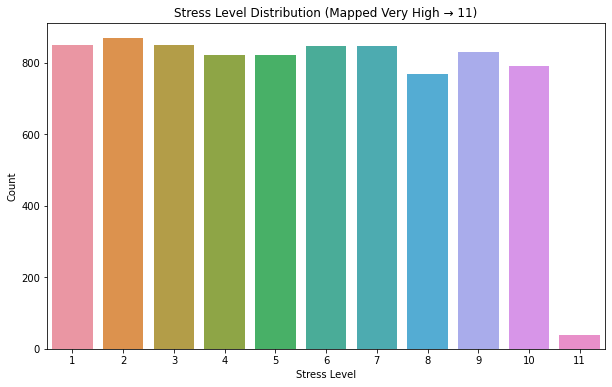

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Map 'Very High' to 11 and convert to int ---
watch_data_encoded['Stress Level'] = watch_data_encoded['Stress Level'].replace('Very High', 11)
watch_data_encoded['Stress Level'] = watch_data_encoded['Stress Level'].astype(int)

# --- 2. Stress Level Distribution Plot ---
plt.figure(figsize=(10,6))

# Specify ordered x-axis
stress_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

sns.countplot(x='Stress Level', data=watch_data_encoded, order=stress_order)

plt.title('Stress Level Distribution (Mapped Very High → 11)')
plt.xlabel('Stress Level')
plt.ylabel('Count')
plt.show()


# Train/Test Split


In [25]:
from sklearn.model_selection import train_test_split

# Features (X) and Label (y)
y = watch_data_encoded["Stress Level"]
X = watch_data_encoded.drop(columns=["Stress Level"])

# Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (6660, 7)
Test shape: (1665, 7)


# Baseline Linear Regression

In [26]:
## Baseline Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Train Linear Regression Model ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# --- Predict on Test Set ---
y_pred_lr = lr_model.predict(X_test)

# --- Evaluate Linear Regression Model ---
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)   # <-- take sqrt manually to get RMSE

print(f"Linear Regression MAE: {mae_lr:.3f}")
print(f"Linear Regression RMSE: {rmse_lr:.3f}")


Linear Regression MAE: 2.534
Linear Regression RMSE: 2.906


# SVM Regression Model

In [27]:
from sklearn.svm import SVR

# --- Train SVM Regression Model ---
svm_model = SVR(kernel='rbf')  # Using RBF kernel (good for non-linear patterns)
svm_model.fit(X_train, y_train)

# --- Predict on Test Set ---
y_pred_svm = svm_model.predict(X_test)

# --- Evaluate SVM Model ---
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)

print(f"SVM Regression MAE: {mae_svm:.3f}")
print(f"SVM Regression RMSE: {rmse_svm:.3f}")


SVM Regression MAE: 2.563
SVM Regression RMSE: 2.955


## Ridge Regression Modelling

In [28]:
from sklearn.linear_model import Ridge

# --- Train Ridge Regression Model ---
ridge_model = Ridge(alpha=1.0)  # alpha is regularization strength, 1.0 is a standard starting point
ridge_model.fit(X_train, y_train)

# --- Predict on Test Set ---
y_pred_ridge = ridge_model.predict(X_test)

# --- Evaluate Ridge Model ---
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

print(f"Ridge Regression MAE: {mae_ridge:.3f}")
print(f"Ridge Regression RMSE: {rmse_ridge:.3f}")


Ridge Regression MAE: 2.534
Ridge Regression RMSE: 2.906


## Ridge Regression with tuned hyperparameters:

In [29]:
from sklearn.linear_model import RidgeCV

# --- Ridge Regression with Cross-Validation for Alpha ---
alphas = np.logspace(-3, 3, 50)  # Test alpha from 0.001 to 1000
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Best alpha found
best_alpha = ridge_cv.alpha_
print(f"Best alpha from CV: {best_alpha:.5f}")

# Predict with best Ridge model
y_pred_ridge_cv = ridge_cv.predict(X_test)

# Evaluate tuned Ridge model
mae_ridge_cv = mean_absolute_error(y_test, y_pred_ridge_cv)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
rmse_ridge_cv = np.sqrt(mse_ridge_cv)

print(f"Tuned Ridge Regression MAE: {mae_ridge_cv:.3f}")
print(f"Tuned Ridge Regression RMSE: {rmse_ridge_cv:.3f}")


Best alpha from CV: 1000.00000
Tuned Ridge Regression MAE: 2.534
Tuned Ridge Regression RMSE: 2.906


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found

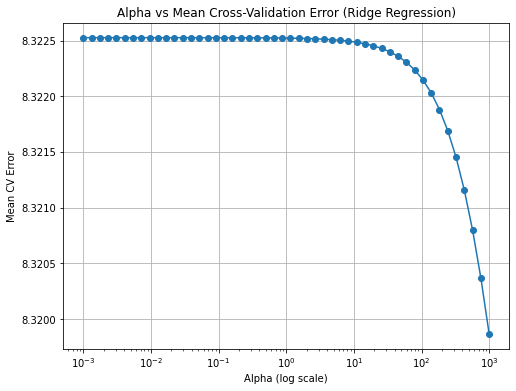

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plot Alpha vs CV Error ---

# Get mean cross-validation errors for each alpha
cv_errors = np.mean(ridge_cv.cv_values_, axis=0)

plt.figure(figsize=(8,6))
plt.plot(ridge_cv.alphas, cv_errors, marker='o', linestyle='-')
plt.xscale('log')  # Use log scale because alpha spans many magnitudes
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean CV Error')
plt.title('Alpha vs Mean Cross-Validation Error (Ridge Regression)')
plt.grid(True)
plt.show()


# Regression Model Comparison:

                    Model       MAE      RMSE
0       Linear Regression  2.534371  2.906245
1          SVM Regression  2.562807  2.954703
2        Ridge Regression  2.534371  2.906244
3  Tuned Ridge Regression  2.534361  2.905999


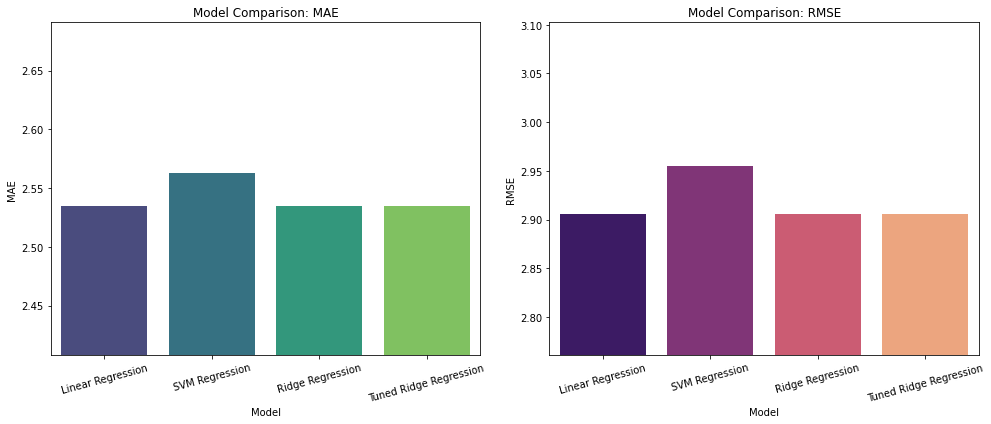

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Updated Results DataFrame including Tuned Ridge ---
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'SVM Regression', 'Ridge Regression', 'Tuned Ridge Regression'],
    'MAE': [mae_lr, mae_svm, mae_ridge, mae_ridge_cv],
    'RMSE': [rmse_lr, rmse_svm, rmse_ridge, rmse_ridge_cv]
})

print(results_df)
# --- Plot Updated Comparison ---

plt.figure(figsize=(14,6))

# Plot MAE
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='MAE', data=results_df, palette='viridis')
plt.ylim(results_df['MAE'].min() * 0.95, results_df['MAE'].max() * 1.05)  # zoom y-axis
plt.title('Model Comparison: MAE')
plt.xticks(rotation=15)

# Plot RMSE
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='RMSE', data=results_df, palette='magma')
plt.ylim(results_df['RMSE'].min() * 0.95, results_df['RMSE'].max() * 1.05)  # zoom y-axis
plt.title('Model Comparison: RMSE')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()


# Feature Importance from Ridge Regression

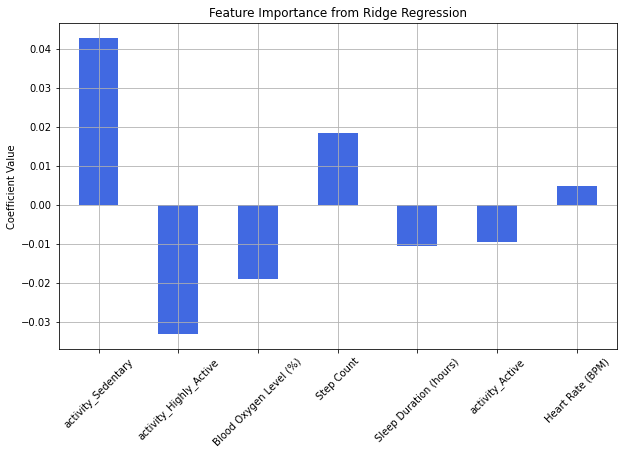

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# --- Refit Ridge with best alpha from RidgeCV ---
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

# --- Feature Importance from Ridge ---
feature_importance = pd.Series(
    ridge_best.coef_,
    index=X_train.columns
).sort_values(key=abs, ascending=False)

# --- Plot Feature Importance ---
plt.figure(figsize=(10,6))
feature_importance.plot(kind='bar', color='royalblue')
plt.title('Feature Importance from Ridge Regression')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# PCA

In [33]:
print(feature_importance)

activity_Sedentary        0.042889
activity_Highly_Active   -0.033305
Blood Oxygen Level (%)   -0.018927
Step Count                0.018483
Sleep Duration (hours)   -0.010446
activity_Active          -0.009584
Heart Rate (BPM)          0.004900
dtype: float64


Heart rate and sleep duration suprisingly are the least important features in our best ridge regression model. We predicted before experimenting that these would be the most important besides activity level, as we thought that these features are some of the best at predicting general health, which we assumed would correlate to stress. Let's remove these features and re-evaluate our model. 

In [34]:
x_reduced = X.drop("Heart Rate (BPM)", axis = 1)
x_reduced = x_reduced.drop("Sleep Duration (hours)", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=42)

ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

y_pred_ridge_cv = ridge_best.predict(X_test)

# Evaluate tuned Ridge model
mae_ridge_cv = mean_absolute_error(y_test, y_pred_ridge_cv)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
rmse_ridge_cv = np.sqrt(mse_ridge_cv)

print(f"Tuned Ridge Regression MAE: {mae_ridge_cv:.3f}")
print(f"Tuned Ridge Regression RMSE: {rmse_ridge_cv:.3f}")


Tuned Ridge Regression MAE: 2.534
Tuned Ridge Regression RMSE: 2.906


The resulting MAEs were almost identical to the MAEs of the original model, which is unsuprising from the viewpoint of our model. The weight on these features were extremely low, which means they would have a very small inpact on the overall effectiveness in our model. However, from an intuition approach, the fact that the model's performance is nearly identical with and without these two features is strange. We predicted that heart rate and especially sleep duration would be the biggest predictors as we assumed that sleep would be highly correlated to stress.

# K-Means Clustering

Silhouette Score for K-Means (3 clusters): 0.156


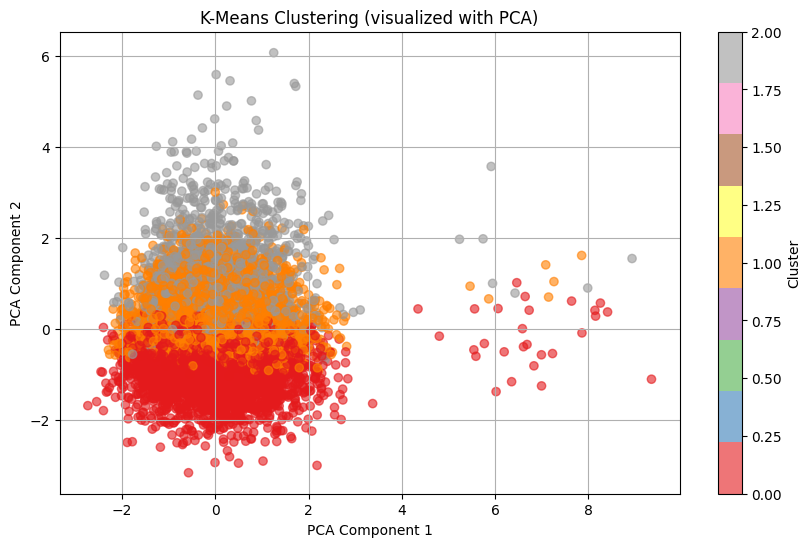

In [24]:
## K-Means Clustering for Stress Patterns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Fit K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# Add cluster labels to DataFrame (for reference/plotting)
watch_data_encoded['Cluster'] = clusters

# Evaluate clustering quality
sil_score = silhouette_score(X, clusters)
print(f"Silhouette Score for K-Means (3 clusters): {sil_score:.3f}")

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Set1', alpha=0.6)
plt.title('K-Means Clustering (visualized with PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()


# Random Forest (Classifier)

Random Forest Classification Report:
              precision    recall  f1-score   support

         Low       0.31      0.24      0.27       540
      Medium       0.39      0.55      0.46       647
        High       0.24      0.16      0.19       478

    accuracy                           0.34      1665
   macro avg       0.31      0.32      0.31      1665
weighted avg       0.32      0.34      0.32      1665



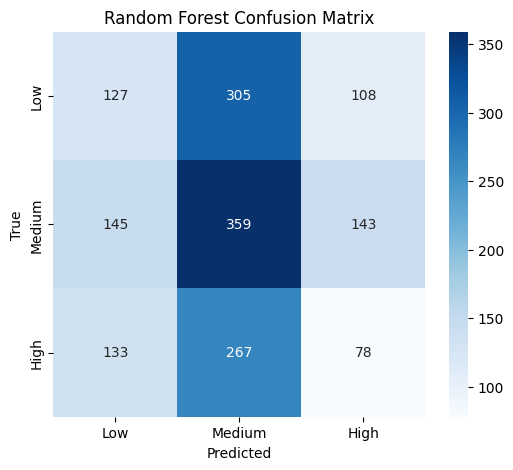

In [25]:
## Random Forest Classifier for Stress Level Prediction

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Bin stress levels into categories: low (1-3), medium (4-7), high (8-11)
def categorize_stress(level):
    if level <= 3:
        return 0  # low
    elif level <= 7:
        return 1  # medium
    else:
        return 2  # high

y_class = watch_data_encoded['Stress Level'].apply(categorize_stress)

# Split data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_clf, y_train_clf)

# Predict and evaluate
y_pred_clf = rf_clf.predict(X_test_clf)

print("Random Forest Classification Report:")
print(classification_report(y_test_clf, y_pred_clf, target_names=['Low', 'Medium', 'High']))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()


# Conclusion



This project explored the possibility of predicting stress levels via health metrics from smartwatch data. We preprocessed the data in multiple ways: error filtering, one-hot encoding, and z-score normalization. This helped us prepare a clean dataset of 8,325 observations with features such as heart rate, oxygen level, step count, sleep duration, and activity level.

Our baseline modeling efforts compared Linear Regression, Ridge Regression (with and without tuning), and Support Vector Regression. Surprisingly, all linear models performed similarly, with ridge regression yielding the best MAE (2.543) and RMSE (2.906). SVM wasn’t notably better, suggesting that the underlying relationship between the predictors and stress levels is most likely linear.

One notable aspect of our findings is the low feature importance of heart rate and sleep duration. These two metrics are very often associated with physical well-being and stress. Intuitively, we expect that these metrics would be highly correlated with stress and prior to creating our models, we predicted that these would be the most important features, whereas heart rate would be the least important, which ended up having the highest weight vector in our PCA. Despite this intuition, removing these features had no significant impact on model performance.

Beyond regression, we explored stress categorization using Random Forests and unsupervised K-means clustering. The classification was more challenging with an overall accuracy of only 34%, which may suggest overlaps and ambiguity in how stress manifests in physiological signals. Clustering showed very limited structure with a (silhouette score of 0.156). This all further reinforces the idea that stress is too complex and multifactorial to be categorized by so few physiological predictors.

Our models always had an MAE of 2.5 - 3, which is less accurate than we would have liked, but our models are still useful in a less precise way. We wouldn’t say our model is accurate enough to get the exact stress level someone would report, but our model can pretty accurately place individuals in buckets. If we had a “low stress”, “moderate stress”, and “high stress” category, we could reasonably expect our model to be able to place individuals close enough to their true values that this would be useful.

We suspect that our models were not highlyall that accurate due to the subjectivity of what a “stress level” is. Not only is this self-reported and has no metrics to aid a person in deciding what value to assign, but people also have different stress tolerances. Two people with the same set of stressors could feel wildly different in how stressed they are, so there is no concrete objectivity to this metric. Given this obstacle, we are proud of our models’ accuracy as we think being off by less than 3 units is extremely precise given the context of the data. 

Ultimately, analyzing this dataset using different machine learning models demonstrates that while stress level prediction from smartwatch data is plausible, it’s very constrained by feature informativeness and likely the inherent subjectivity in stress reporting. Some helpful improvements to a dataset, if this data were recorded again, would include time-series modeling and user baselines for each smart watch reading feature. This would allow us to draw more meaningful conclusions from the data, most likely.

If we were to expand on this dataset, we would alter our models to predict objective features within this set, such as heart rate. We would be curious if the reported stress levels would be a significant feature for prediction, or if it would be too subjective to draw any meaningful correlation from. Would the more objective features, like blood pressure, account for most of the weight of our models?

We would also be curious if we could notably improve upon our stress level prediction by using more complex neural networks. We’d want to see if it would be possible to get more accurate results, as we would consider our model highly accurate if we could get our MAE under 1 unit. Can the subjectiveness of the stress units be “overcome”?

